# Simple Shapes

## Setup

In [1]:
import os
import imageio
from collections import deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline  

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.1.0


In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10065134609254527129, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4997992278606443252
 physical_device_desc: "device: XLA_CPU device"]

## Load Data

In [59]:
NUMPIXELS = 32
INPUTSHAPE = (NUMPIXELS, NUMPIXELS, 1)
NUMCLASSES = 2
DATASIZE = 50000

In [60]:
data_path = os.path.join('/', 'home', 'jupyter', 'taureau', '_data')
shapes_path = os.path.join(data_path, 'simple_shapes', 'simple_shapes_'+str(NUMPIXELS))

In [61]:
def load_data(shapes_path):
    shape_info = pd.read_csv(os.path.join(shapes_path, 'data.csv'), header=None, names=["uid","shape","x0","y0","x1","y1"])
    shape_info = shape_info.sort_values('uid').reset_index(drop=True)
    shape_info.replace({'Ellipse':0, 'Rectangle':1}, inplace=True)
    shape_info = shape_info[shape_info.uid<=DATASIZE]
    img_data = deque()
    for uid in shape_info.uid.values:
        im = imageio.imread(os.path.join(shapes_path, 'images', 'img_'+str(uid)+'.png'))
        img_data.append(im)
    img_data = np.array(img_data)
    return (img_data, shape_info.values)

In [62]:
%%time

(x_data, y_data) = load_data(shapes_path)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train = x_train.reshape(len(x_train), NUMPIXELS, NUMPIXELS, 1).astype('float32')/255
x_test = x_test.reshape(len(x_test), NUMPIXELS, NUMPIXELS, 1).astype('float32')/255

y_cls_train = tf.keras.utils.to_categorical(y_train[:,1])
y_cls_test = tf.keras.utils.to_categorical(y_test[:,1])

y_reg_train = y_train[:,2:6]
y_reg_test = y_test[:,2:6]

CPU times: user 33.4 s, sys: 6.26 s, total: 39.6 s
Wall time: 9min 8s


## Classification

In [202]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(NUMCLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_cnn')

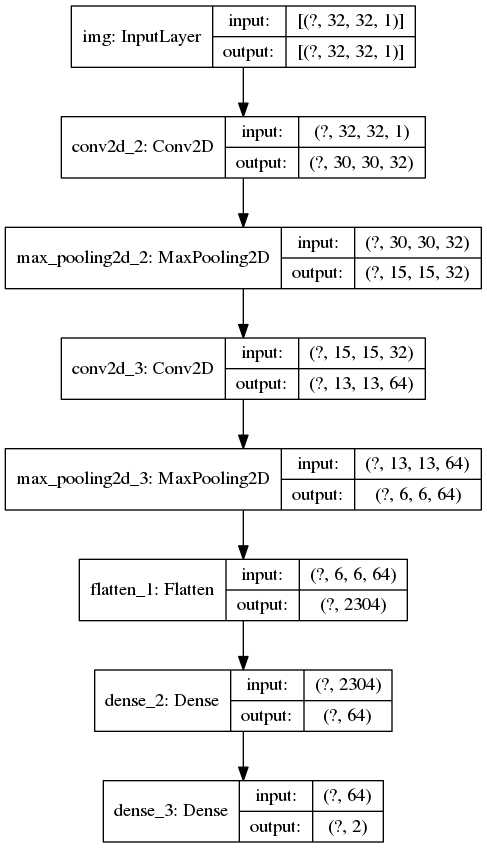

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [203]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [91]:
history = model.fit(x_train, y_cls_train,
                    batch_size=64,
                    epochs=5
                   )
#                     ,
#                     validation_split=0.2)

Train on 1600 samples
Epoch 1/5
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7164 - accuracy: 0.5806
Epoch 2/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5571 - accuracy: 0.7525
Epoch 3/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3472 - accuracy: 0.8850
Epoch 4/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2634 - accuracy: 0.9100
Epoch 5/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1565 - accuracy: 0.9581


In [92]:
test_scores = model.evaluate(x_test, y_cls_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

400/400 - 1s - loss: 0.0961 - accuracy: 0.9950
Test loss: 0.09607559204101562
Test accuracy: 0.995


[[0.997 0.003]]


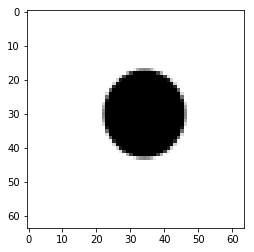

In [117]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
shape_pred = np.round(model.predict(np.array([img_r])), 3)
print(shape_pred)

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

plt.show()

## Regression

**NOTES**
Ideas for improvement:
- add one or more conv layers (see Chollet p141)
- add dropout layer after flatten 
- use custom loss that includes IOU term

In [271]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(4)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_cnn')

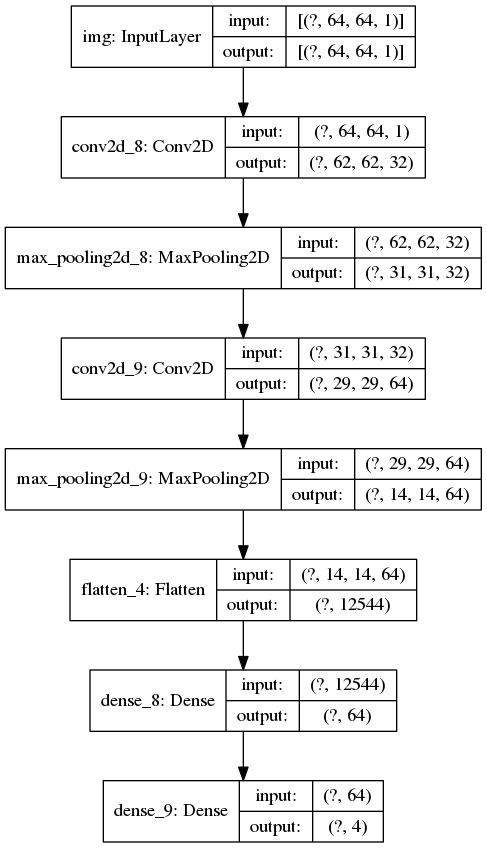

In [121]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [272]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mse'])

In [273]:
history = model.fit(x_train, y_reg_train,
                    batch_size=64,
                    epochs=10
                   )
#                     ,
#                     validation_split=0.2)

Train on 16000 samples
Epoch 1/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 115.4610 - mse: 115.4611
Epoch 2/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 11.0522 - mse: 11.0522
Epoch 3/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 5.1231 - mse: 5.1231
Epoch 4/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 3.2871 - mse: 3.2871
Epoch 5/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 2.3336 - mse: 2.3336
Epoch 6/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.7326 - mse: 1.7326
Epoch 7/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.3979 - mse: 1.3979
Epoch 8/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 1.1845 - mse: 1.1845
Epoch 9/10
16000/16000 [==============================] - 34s 2ms/sample - loss: 1.0479 - mse: 1.0479
Epoch 10/10
16000/16000 [============================

In [274]:
test_scores = model.evaluate(x_test, y_reg_test, verbose=2)
print('Test loss:', test_scores[0])

4000/4000 - 3s - loss: 0.9836 - mse: 0.9836
Test loss: 0.9835799083709716


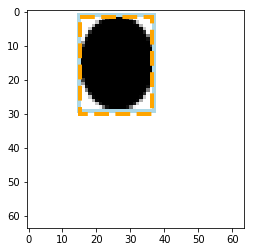

In [288]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
bbox_orig = y_reg_test[ind_r]
bbox_pred = model.predict(np.array([img_r]))[0]

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

rect = patches.Rectangle((bbox_orig[0]-1, (NUMPIXELS-bbox_orig[1])-(bbox_orig[3]-bbox_orig[1])),bbox_orig[2]-bbox_orig[0],bbox_orig[3]-bbox_orig[1], 
                         linewidth=4, edgecolor='lightblue', facecolor='none')
ax1.add_patch(rect)

rect2 = patches.Rectangle((bbox_pred[0]-1, (NUMPIXELS-bbox_pred[1])-(bbox_pred[3]-bbox_pred[1])),bbox_pred[2]-bbox_pred[0],bbox_pred[3]-bbox_pred[1], 
                         linewidth=4, edgecolor='orange', ls='--', facecolor='none')
ax1.add_patch(rect2)

plt.show()

## Regression + Classification

In [289]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_cls = layers.Dense(NUMCLASSES, activation='softmax')(x)
output_reg = layers.Dense(4)(x)
model = tf.keras.Model(inputs=inputs, outputs=[output_cls, output_reg], name='mnist_cnn')

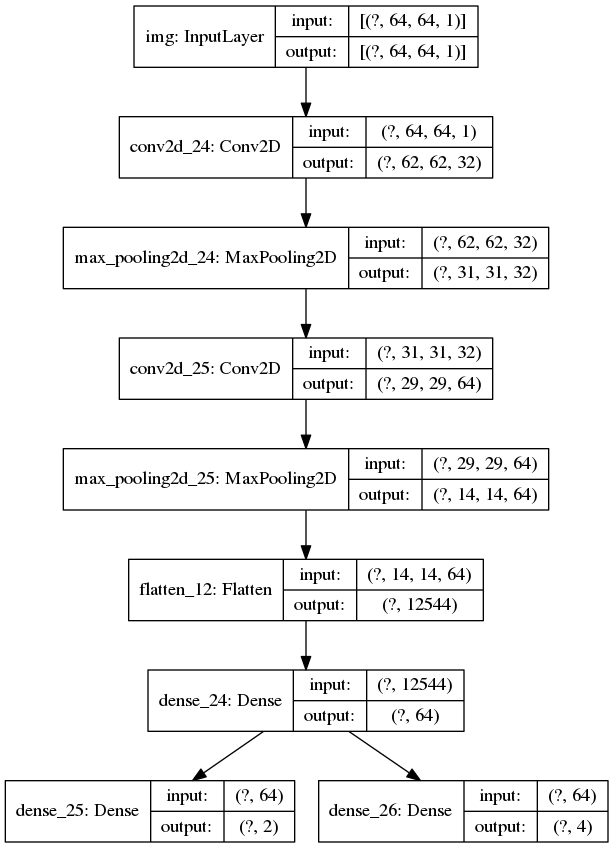

In [290]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [291]:
model.compile(loss=['categorical_crossentropy', 'mse'],
              optimizer=tf.keras.optimizers.Adam()
             )

In [293]:
history = model.fit(x_train, [y_cls_train, y_reg_train],
                    batch_size=64,
                    epochs=10
                   )
#                     ,
#                     validation_split=0.2)

Train on 16000 samples
Epoch 1/10
16000/16000 [==============================] - 37s 2ms/sample - loss: 101.7949 - dense_25_loss: 1.0211 - dense_26_loss: 100.7738
Epoch 2/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 15.3416 - dense_25_loss: 0.7915 - dense_26_loss: 14.5501
Epoch 3/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 5.9286 - dense_25_loss: 0.7099 - dense_26_loss: 5.2187
Epoch 4/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 3.6997 - dense_25_loss: 0.6141 - dense_26_loss: 3.0856
Epoch 5/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 2.8812 - dense_25_loss: 0.5400 - dense_26_loss: 2.3412
Epoch 6/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 2.3443 - dense_25_loss: 0.4479 - dense_26_loss: 1.8964
Epoch 7/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.6271 - dense_25_loss: 0.3335 - dense_26_loss: 1.2936
Epoch 8/10
16000/16

In [294]:
test_scores = model.evaluate(x_test, [y_cls_test, y_reg_test], verbose=2)
print('Test loss:', test_scores)

4000/4000 - 4s - loss: 1.2344 - dense_25_loss: 0.1660 - dense_26_loss: 1.0684
Test loss: [1.2344109292030334, 0.16596156, 1.0684495]


[0.926 0.074]


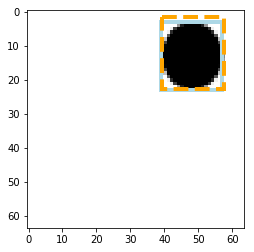

In [321]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
bbox_orig = y_reg_test[ind_r]
[shape_pred, bbox_pred] = model.predict(np.array([img_r]))
shape_pred = np.round(shape_pred[0], 3)
bbox_pred = bbox_pred[0]
print(shape_pred)

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

rect = patches.Rectangle((bbox_orig[0]-1, (NUMPIXELS-bbox_orig[1])-(bbox_orig[3]-bbox_orig[1])),bbox_orig[2]-bbox_orig[0],bbox_orig[3]-bbox_orig[1], 
                         linewidth=4, edgecolor='lightblue', facecolor='none')
ax1.add_patch(rect)

rect2 = patches.Rectangle((bbox_pred[0]-1, (NUMPIXELS-bbox_pred[1])-(bbox_pred[3]-bbox_pred[1])),bbox_pred[2]-bbox_pred[0],bbox_pred[3]-bbox_pred[1], 
                         linewidth=4, edgecolor='orange', ls='--', facecolor='none')
ax1.add_patch(rect2)

plt.show()

## Variational Autoencoder

**NOTES**

Potential questions to pursue further:

You do not see any obvious separation between rectangles and ellipses in the latent space (5-d scatter matrix, or t-sne). It would be interesting to figure out how to 'disentangle' shape(1), position(2), and size(2). If they were truely disentangled, you could easily dial in whatever shape you wanted feeding into the decoder. But, I'm not really interested in generating shapes. I'm more interested in having the model fit shape primitives to the input image. 

You could investigate how to set up a latent space that forces the model to choose between two discrete shapes. You have several papers that demonstrate this approach for both 2d and 3d primitives. I think there is a way to not explicitly force the exact shape, e.g. rectangle or ellipse, but instead let the network figure out those two shapes for itself, by explicitly factoring out the position and size: think of those as transformations of the underlying shape, i.e. translation and scaling.

This investigation will be more interesting using more complex shapes that are not identical to the idealized primitives, but I think you can learn something already using these simple shapes...learn how to set up the network and loss functions properly.

You might also consider how you could accomplish something similar with a GAN.

In [63]:
LATENTDIM = 5

In [64]:
output_file = 'vae_simple_shapes'
output_filepath = os.path.join('/', 'home', 'jupyter', 'taureau', '_model_assets', 'checkpoints', output_file+'.hdf5')

### Train model

In [65]:
def gaussian_sampling(args):
    mu0, log_var0 = args
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu0), mean=0., stddev=1.)
    return mu0 + tf.keras.backend.exp(log_var0 / 2) * epsilon


# define encoder
enc_inputs = tf.keras.Input(shape=INPUTSHAPE, name='enc_input')
x = layers.Conv2D(16, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(enc_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        padding = 'same')(x)    
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        padding = 'same')(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        padding = 'same')(x)

shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
x = layers.Flatten()(x)

# x = layers.Dense(32, activation='relu')(x)

z_mu = layers.Dense(LATENTDIM, name='mu')(x)
z_log_var = layers.Dense(LATENTDIM, name='log_var')(x)
# encoder_mu_log_var = tf.keras.Model(inputs=enc_inputs, outputs=(mu, log_var), name='encoder_mu_log_var')
enc_outputs = layers.Lambda(gaussian_sampling, output_shape=(LATENTDIM,), name='enc_output')([z_mu, z_log_var])
enc_model = tf.keras.Model(inputs=enc_inputs, outputs=enc_outputs, name='encoder')


# define decoder
dec_inputs = tf.keras.Input(shape=(LATENTDIM,), name='dec_input')
x = layers.Dense(np.prod(shape_before_flattening))(dec_inputs)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(16, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(1, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  padding = 'same',
                  activation='sigmoid',
                  name='dec_output')(x)
dec_model = tf.keras.Model(dec_inputs, x, name='decoder')
dec_outputs = dec_model(enc_outputs)

# define custom layer to house the custom loss
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x_input, x_decoder, x_mu, x_log_var):
        xin = tf.keras.backend.flatten(x_input)
        xout = tf.keras.backend.flatten(x_decoder)
        bce_loss = tf.keras.metrics.binary_crossentropy(xin, xout)
        kl_loss = -2*5e-4 * tf.keras.backend.mean(1 + x_log_var - tf.keras.backend.square(x_mu) - tf.keras.backend.exp(x_log_var), axis=-1)
        return tf.keras.backend.mean(bce_loss + kl_loss)

    def call(self, inputs):
        x_input = inputs[0]
        x_decoder = inputs[1]
        x_mu = inputs[2]
        x_log_var = inputs[3]
        loss = self.vae_loss(x_input, x_decoder, x_mu, x_log_var)
        self.add_loss(loss, inputs=inputs)
        return x_decoder

# We call our custom layer on the input and the decoded output, to obtain the final model output.
var_loss_outputs = CustomVariationalLayer()([enc_inputs, dec_outputs, z_mu, z_log_var])

model_vae = tf.keras.Model(enc_inputs, var_loss_outputs)
model_vae.compile(optimizer=tf.keras.optimizers.Adam())

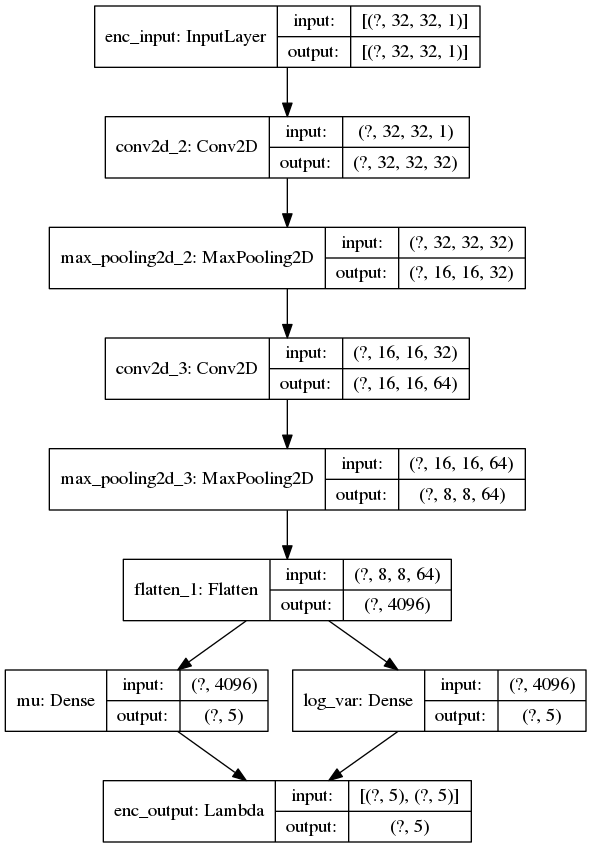

In [38]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)

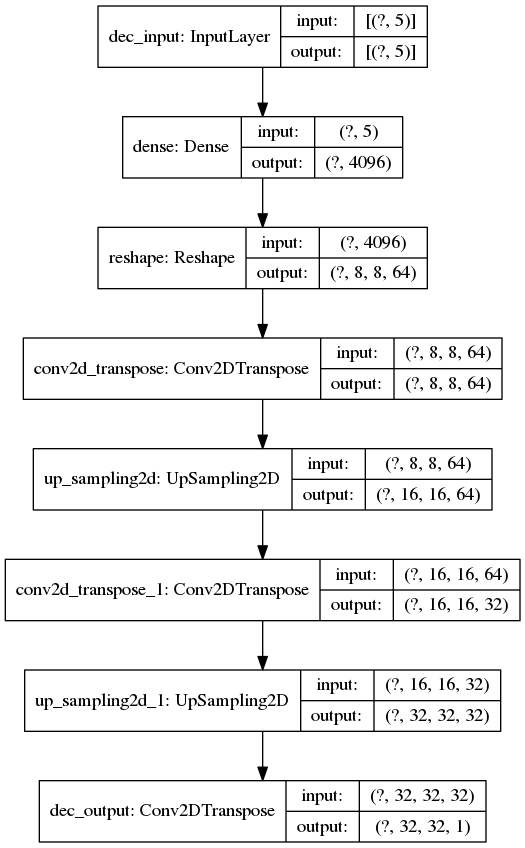

In [31]:
tf.keras.utils.plot_model(dec_model, show_shapes=True)

In [66]:
# %time

# checkpointer = tf.keras.callbacks.ModelCheckpoint(output_filepath, verbose=1, save_best_only=True)
# earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)

# history = model_vae.fit(x_train, None,
#                        batch_size=32,
#                        epochs=50
#                         ,
#                        validation_split=0.2
#                         ,
#                        callbacks=[checkpointer, earlystopper]
#                    )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Train on 32000 samples, validate on 8000 samples
Epoch 1/50
31968/32000 [============================>.] - ETA: 0s - loss: 0.0640
Epoch 00001: val_loss improved from inf to 0.03820, saving model to /home/jupyter/taureau/_model_assets/checkpoints/vae_simple_shapes.hdf5
32000/32000 [==============================] - 69s 2ms/sample - loss: 0.0640 - val_loss: 0.0382
Epoch 2/50
31968/32000 [============================>.] - ETA: 0s - loss: 0.0374
Epoch 00002: val_loss improved from 0.03820 to 0.03545, saving model to /home/jupyter/taureau/_model_assets/checkpoints/vae_simple_shapes.hdf5
32000/32000 [==============================] - 77s 2ms/sample - loss: 0.0374 - val_loss: 0.0354
Epoch 3/50
31968/32000 [============================>.] - ETA: 0s - loss: 0.0340
Epoch 00003: val_loss improved from 0.03545 to 0.03175, saving model to /home/jupyter/taureau/_model_assets/checkpoints/vae_simple_shapes.hdf5
32000/32000 [==============

#### Load saved model

In [67]:
model_vae = tf.keras.models.load_model(
    output_filepath,
    custom_objects={'CustomVariationalLayer': CustomVariationalLayer},
    compile=True
)

enc_vae = tf.keras.Model(inputs=model_vae.input,
                           outputs=model_vae.get_layer('mu').output)
dec_vae = model_vae.get_layer(index=-2)

#### Training/Test image preservation

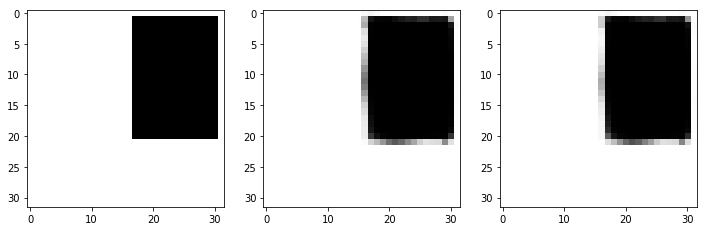

In [73]:
ind_r = np.random.randint(len(x_train))
# print(ind_r)

img_r = x_train[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)

img_vae = model_vae.predict(np.array([img_r])).reshape(NUMPIXELS, NUMPIXELS)
img_enc = enc_vae.predict(np.array([img_r]))
img_dec = dec_vae.predict(img_enc).reshape(NUMPIXELS, NUMPIXELS)
 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
ax1.imshow(img_orig, cmap='gray')
ax2.imshow(img_vae, cmap='gray')
ax3.imshow(img_dec, cmap='gray')

plt.show()

#### Mapping to latent space

In [74]:
# x_train_encoded = enc_vae.predict(x_train)
x_test_encoded = enc_vae.predict(x_test)
x_test_enc_df = pd.DataFrame(x_test_encoded)

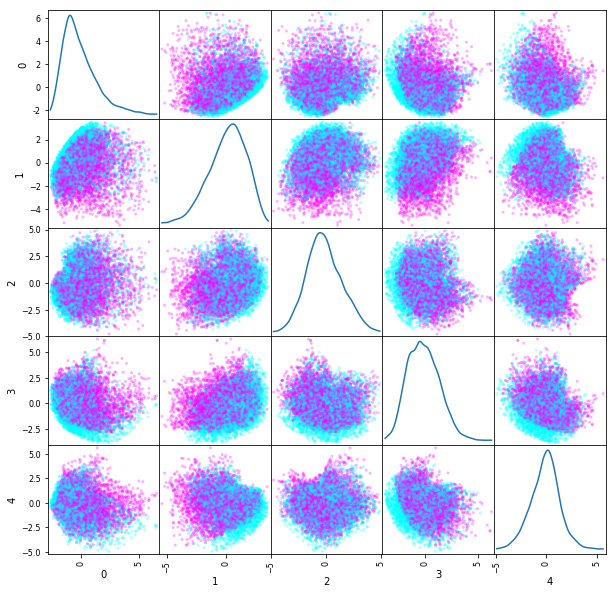

In [75]:
pd.plotting.scatter_matrix(x_test_enc_df, c = y_test[:,1], figsize = (10,10), diagonal = 'kde', cmap='cool', alpha=0.3)

plt.show()

In [78]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(x_test_encoded)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.516s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.508352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.404427
[t-SNE] Error after 1000 iterations: 1.748002


In [79]:
tsne_results.shape

(10000, 2)

In [ ]:
plt.scatter

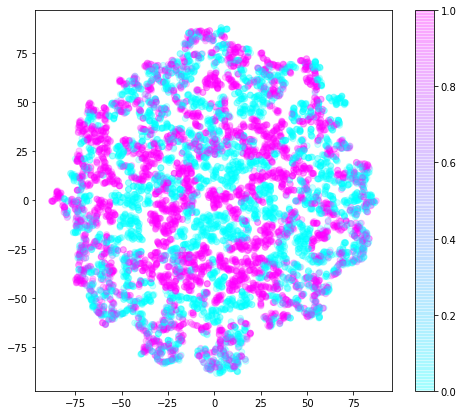

In [82]:
plt.figure(figsize=(8,7))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_test[:,1], cmap='cool', alpha=0.2)
plt.colorbar()

plt.show()